<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sunspot-Dataset" data-toc-modified-id="Sunspot-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sunspot Dataset</a></span><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the Data</a></span></li><li><span><a href="#Descriptive-Analysis" data-toc-modified-id="Descriptive-Analysis-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Descriptive Analysis</a></span></li></ul></li><li><span><a href="#Pre-process-for-TADA" data-toc-modified-id="Pre-process-for-TADA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-process for TADA</a></span></li><li><span><a href="#tsExtract:-Time-Series-Preprocessing-Library" data-toc-modified-id="tsExtract:-Time-Series-Preprocessing-Library-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>tsExtract: Time Series Preprocessing Library</a></span><ul class="toc-item"><li><span><a href="#TADA-prediction" data-toc-modified-id="TADA-prediction-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TADA prediction</a></span></li><li><span><a href="#Prediction-with-SARIMA/ARIMA" data-toc-modified-id="Prediction-with-SARIMA/ARIMA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prediction with SARIMA/ARIMA</a></span></li><li><span><a href="#Comparison-TADA-VS-ARIMA" data-toc-modified-id="Comparison-TADA-VS-ARIMA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparison TADA VS ARIMA</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></div>

# Sunspot Dataset

The main goal of this Notebook is given Sunspot Dataset try to compare two different model for predicting time series: 
 
 - SARIMA/ARIMA model 
 - TADA model 



In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

## Load the Data 

In [4]:
pwd

'/Users/nicolaronzoni/Desktop/UCA/case_study'

In [5]:
series= pd.read_csv("Sunspots.csv",header=0, index_col=1)

In [6]:
series

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7
...,...,...
2019-08-31,3247,0.5
2019-09-30,3248,1.1
2019-10-31,3249,0.4


Delete the index column such that the new index column will be the date of the observation.

In [7]:
series=series.drop(columns=['Unnamed: 0'],axis=1)

In [8]:
series

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4


## Descriptive Analysis  

<Figure size 1080x720 with 0 Axes>

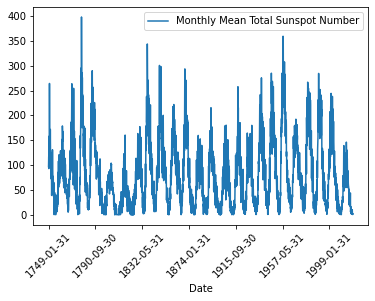

In [9]:
plt.figure(figsize=(15,10))
series.plot()
plt.xticks(rotation=45)
plt.show()

The dataset shows seasonality with large differences between seasons.

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
X=series.values

In [12]:
X

array([[ 96.7],
       [104.3],
       [116.7],
       ...,
       [  0.4],
       [  0.5],
       [  1.6]])

Global and partial autocorrelation 

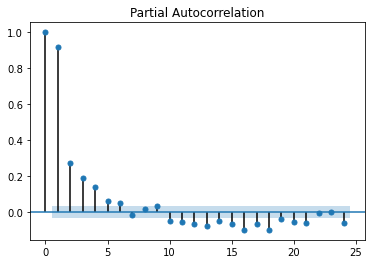

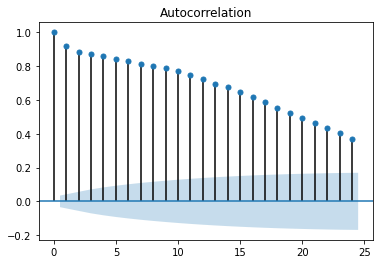

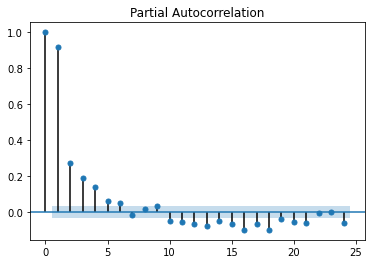

In [13]:
plot_acf(X, lags=24)
plot_pacf(X,lags=24)

The main difference between Partial and Global autocorrelation is that in the Partial one the influences of the middle observations are not taken in account.

Decomposition of the time series: 

 - Additive Model 

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

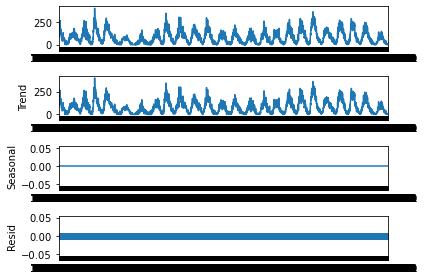

In [23]:
#time series decomposition 'additive model' Level + Trend + Seasonality + Noise
#the behavior is linear where changes over time are consistently made by the same amount, like a linear trend.
#In this situation, the linear seasonality has the same amplitude and frequency,
#This mean that the magnitude of seasonality does not change in relation to time.
decomposition = seasonal_decompose(series, model='additive', period=1)
decomposition.plot()
plt.show()

  - Multiplicative model, Unfortunately this decomposition doesn't work when we have zero values inside the series

In [ ]:
#time series decomposition 'additive model' Level * Trend * Seasonality * Noise
#the behavior is not linear, can be exponential or quadratic .
#In this situation,  the multiplicative model has an increasing or decreasing amplitude and/or frequency over time.,
#This mean that the magnitude of seasonality  change in relation to time.
decomposition = seasonal_decompose(series,model='multiplicative', period=1)
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
plt.show()

 plot of First order difference

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text major ticklabel objects>)

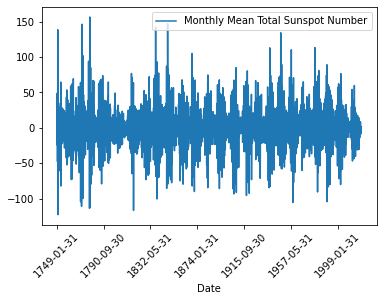

In [15]:
series.diff(1).plot()
plt.xticks(rotation=45)

plot of seasonal difference 

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text major ticklabel objects>)

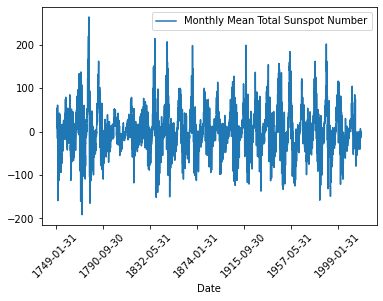

In [17]:
series.diff(12).plot()
plt.xticks(rotation=45)

In both case we obtain a stationarity representation. 

# Pre-process for TADA 

In order to pre-process time series and convert it to a form that can be fed into standard machine learning regression algorithm, such as TADA, we have to define a sliding window of data. 
Given a sequence of numbers for a time series dataset, we can restructure data to look like a supervised learning problem. We can do this by using previous time steps as input variables and use the next time step as the output variable. 


But now the question is How many previous step i have to consider in order to create significant features?
Of course this depend on the data, we can look at the autocorrelation plots, but we can implement a grid search in order to decide the best size window among a set of choice that minimaize the error.  

In [27]:

# grid search persistence models
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error


#The train_test_split() function below will split the series
#taking the raw observations and the number of observations to use in the test set as arguments.

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


#First, the dataset is split into train and test sets. 
#We will call the train_test_split() function
#to perform this split and pass in the pre-specified number of observations to use as the test data.

#A model will be fit once on the training dataset for a given configuration.

# fit a model
def model_fit(train, config):
    return None

#Each time step of the test dataset is enumerated.
#A prediction is made using the fit model.
#Again, we will define a generic function named model_predict()
#that takes the fit model, the history, and the model configuration 
#and makes a single one-step prediction. 

# forecast with a pre-fit model
def model_predict(model, history, offset):
    return history[-offset]

#We will calculate the root mean squared error, or RMSE,
#between predictions and the true values.
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

#The prediction is added to a list of predictions
#and the true observation from the test set is added to a list of observations that was seeded with all observations from the training dataset. This list is built up during each step in the walk-forward validation, allowing the model to make a one-step prediction using the most recent history.

#All of the predictions can then be compared to the true values in the test set
#and an error measure calculated.

#We will calculate the root mean squared error, or RMSE, between predictions and the true values.

 
# walk-forward validation for univariate data
#takes the dataset, the number of observations to use as the test set, and the configuration for the model, 
#and returns the RMSE for the model performance on the test set.
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error
 
#Repeat evaluation: 
#Genetic Algorithm are adaptive
#Given the same model configuration and the same training dataset, 
#a different set of weights will result each time, this mean that we could have different performance. 

#This is a benefit because the model find high performing configurations to complex problem 
#However it is also a problem when evaluating the performance of a model and choosing a final model to predict. 

#To address model evaluation, 
#we will evaluate a model configuration multiple times via walk-forward validation
#and report the error as the average error across each evaluation.
#but indeed this is not always possible especially when we deal with computational intense algorithms where a lot of weights must be set. 

#The repeat_evaluate() function below implements this
#and allows the number of repeats to be specified as an optional parameter
#that defaults to 1 and returns the mean RMSE score from all repeats.

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=1):
    # convert config to a key
    key = str(config)
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    # summarize score
    result = mean(scores)
    print('> Model[%s] %.3f' % (key, result))
    return (key, result)


#All that is left is a function to drive the search.
#We can define a grid_search() function that takes
#the dataset, a list of configurations to search, and the number of observations to use as the test set 
#and perform the search.
 
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores




After having create the function, we apply it to our data. We decide to split the train and test set considering as a test just the last observation.
We take into account the best 6 models. 

In [28]:
# define dataset

data = X
# data split
n_test = 1
# model configs
cfg_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,24,36,48]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:6]:
    print(cfg, error)

 > 1.100
> Model[1] 1.100
 > 1.200
> Model[2] 1.200
 > 0.500
> Model[3] 0.500
 > 1.100
> Model[4] 1.100
 > 0.700
> Model[5] 0.700
 > 0.400
> Model[6] 0.400
 > 8.300
> Model[7] 8.300
 > 7.500
> Model[8] 7.500
 > 7.800
> Model[9] 7.800
 > 0.800
> Model[10] 0.800
 > 6.100
> Model[11] 6.100
 > 1.500
> Model[12] 1.500
 > 3.300
> Model[13] 3.300
 > 3.300
> Model[14] 3.300
 > 1.700
> Model[15] 1.700
 > 7.100
> Model[16] 7.100
 > 0.000
> Model[17] 0.000
 > 14.000
> Model[18] 14.000
 > 6.600
> Model[24] 6.600
 > 16.900
> Model[36] 16.900
 > 56.400
> Model[48] 56.400
done
17 0.0
6 0.40000000000000013
3 0.5
5 0.7000000000000001
10 0.8
1 1.1


Best 6 previous steps to predict one step forward are showed above. The best ones are selected by computing the RMSE in the walk forward validation process.   

# tsExtract: Time Series Preprocessing Library

tsExtract is a time series preprocessing library. Using sliding windows, tsExtract allows for the conversion of time series data to a form that can be fed into standard machine learning regression algorithms like Linear Regression, Decision Trees Regression as well as Deep Learning.

In [64]:
pip install tsextract

     |████████████████████████████████| 4.4 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 5.0 MB/s eta 0:00:01
ERROR: mizani 0.7.2 has requirement pandas>=1.1.0, but you'll have pandas 1.0.5 which is incompatible.
ERROR: plotnine 0.7.1 has requirement pandas>=1.1.0, but you'll have pandas 1.0.5 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Main Feature:
- Take sliding window of data and with that, create additional columns representing the window.
- Perform differencing on windowed data to remove non-stationarity.
- Calculate statistics on windowed and differenced data. These include temporal and spectral statistics functions.
- Plot visualisations.

Using the main build_features function: build_features takes in 4 arguments:

- Data: Time series data in 1d.

- Feature Request: Dictionary with the function type and parameters

- Include_tzero (optional) - This gives the option on whether to include the column t+0. Can be quite handy when implementing difference networks.

- target_lag - Sets lag value. Default is 3. If we put target_lag=12 the target for Date 2018-12-31 is the value on 2019-12-31. In general the target at the time t is Xt+lag_score


Feature:
 
- window: Takes sliding window of the data. A single value will take a sliding window corresponding to that value. A parameter of [10] will take window from 1 to 10. if [5,10] passed then a window of 5 to 10 steps will be taken instead. 
- window_statistic:This perform windowing like above, but then applies specified statistic operation to reduce a matrix to a vector of 1d. 
- difference/momentum/force:Performs differencing by subtracting from the value in the present time step, the value in the previous time step. The parameter expected is a list of size 2 or 3. Like in the windowing the first 2 values refer to the window size. As in the window just one parameter could be taken. The final value is the lag, this refer to the differencing lag for subtraction.
- difference_statistic/momentum_statistic/force_statistic: Similarly, this performs the operations described above, but then applies the specified statistic. 

Supported features for summary statistic: 
-    STATISTICS     --        TEMPORAL
-   Mean            --       Absolute energy
-   Median          --       AUC
-    Range          --        Mean Absolute difference 
-    Standard Deviation--     Moment 
-    Minimum        --        Autocorrelation
-    Maximum        --        Zero Crossing Rate

In [92]:
from tsextract.feature_extraction.extract import build_features
from tsextract.domain.statistics import median, mean, skew, kurtosis, std
from tsextract.domain.temporal import abs_energy

features_request = {
    "window":[17], # Xt-1, Xt-2, Xt-3, Xt-4,Xt-5,Xt-6,....,Xt-17  features for Xt+1 (Select then the best ones based on the grid search)
    #for the below features, we create it just to explore the feature creation tools of tsextract.
    "window_statistic":[12, std], #standard deviation of(Xt-1,Xt-2,Xt-3,....,Xt-12) feature for Xt+1 --> Seasonality 
    "difference":[13,12], #(Xt-Xt-12) features for Xt ---> Stationarity
    "difference_statistic":[3,1, abs_energy], #(Xt-Xt-1)^2+(Xt-1-Xt-2)^2 feature for Xt 
}

features = build_features(series['Monthly Mean Total Sunspot Number'], features_request, include_tzero=True, target_lag=1)
# our goal is to predict one step forward target_lag=1. 

In [93]:
features

,T-17,T-16,T-15,T-14,T-13,T-12,T-11,T-10,T-9,T-8,...,T-5,T-4,T-3,T-2,T-1,window_statistic_12_std,difference_13_12-1,difference_statistic_3_1_abs_energy,tzero,Target_Tplus1
Date,,,,,,,,,,,,,,,,,,,,,
1750-06-30,96.7,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,...,122.2,126.5,148.7,147.2,150.0,37.875332,27.5,286.73,166.7,142.3
1750-07-31,104.3,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,...,126.5,148.7,147.2,150.0,166.7,38.180412,-15.7,874.25,142.3,171.7
1750-08-31,116.7,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0,...,148.7,147.2,150.0,166.7,142.3,38.119683,61.2,1459.72,171.7,152.0
1750-09-30,92.8,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0,122.2,...,147.2,150.0,166.7,142.3,171.7,36.871740,25.5,1252.45,152.0,109.5
1750-10-31,141.7,139.2,158.0,110.5,126.5,125.8,264.3,142.0,122.2,126.5,...,150.0,166.7,142.3,171.7,152.0,36.018271,-16.3,2194.34,109.5,105.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,10.7,2.5,8.9,13.1,15.6,1.6,8.7,3.3,4.9,4.9,...,0.8,9.4,9.1,9.9,1.2,3.285786,-0.7,75.78,0.9,0.5
2019-08-31,2.5,8.9,13.1,15.6,1.6,8.7,3.3,4.9,4.9,3.1,...,9.4,9.1,9.9,1.2,0.9,3.357858,-8.2,0.25,0.5,1.1
2019-09-30,8.9,13.1,15.6,1.6,8.7,3.3,4.9,4.9,3.1,7.7,...,9.1,9.9,1.2,0.9,0.5,3.434981,-2.2,0.52,1.1,0.4


Save the csv dataset in order to use it on TADA

In [29]:
features.to_csv(r'/Users/nicolaronzoni/Desktop/UCA/case_study/feature.csv', index = True, header=True)

## TADA prediction 

I created 21 features that can be used for predict one step forward. In TADA i will use only the most important ones, by using the search grid previously computed: 

- Xt (tzero)
- Xt-1 (T-1)
- Xt-2 (T-2)
- Xt-3 (T-3)
- Xt-4 (T-4)
- Xt-5 (T-5)
- Xt-6 (T-6)
- Xt-10 (T-10)
- Xt-17 (T-17)
9 features to predict Xt+1 (our goal) as input. 

We use all observation available, we didn't delete any observation. 

 As a result e obtain a global score model of 69%. TADA get this result only using a subset of the input features (7 features): 

- Xt
- Xt-1
- Xt-2
- Xt-5
- Xt-6
- Xt-10
- Xt-17


In [31]:
import math

abs = math.fabs
ceiling = math.ceil
cos = math.cos
exp = math.exp
floor = math.floor
log = math.log
sin = math.sin
sqrt = math.sqrt
truncate = math.trunc

variables = ["T-2", "T-6", "T-1", "T-10", "T-17", "T-5", "tzero"]


def check_sample(sample: pd.Series):
    for variable in variables:
        if variable not in sample.index:
            raise Exception("Variable error: {} not present in input".format(variable))


def predict(sample: pd.Series) -> float:
    check_sample(sample)

    column_1 = float(sample["T-2"])
    column_3 = float(sample["T-6"])
    column_4 = float(sample["T-1"])
    column_5 = float(sample["T-10"])
    column_6 = float(sample["T-17"])
    column_7 = float(sample["T-5"])
    tzero = float(sample["tzero"])

    try:
        return 0.240677198798674*column_4 + 0.0020811434064103*column_6 + 0.58962172176905*tzero - 0.00123650793945041*sqrt(abs(0.115938048371099*(column_3 + column_4) + 0.884061951628901*abs(column_4)))*column_4 - 0.000329377042421718*truncate(0.115938048371099*(column_3 + column_4) + 0.884061951628901*abs(column_4))*column_4 + 0.152240464761094*sqrt(abs(column_5)) - 0.622312003332226*sqrt(abs(column_6)) + 0.761777641582889*sqrt(abs(column_7)) + 0.0406427826989511*floor(column_5) + 0.323790283552682*floor(column_7) - 0.662946381672931*ceiling(0.701731898985275*sqrt(abs(column_7)) + 0.298268101014725*floor(column_7)) + 0.995189185299062*sin(tzero) - 0.000132057906492641*cos(column_4) + 0.507881246487279*cos(0.613916227969787*(column_1 - column_6) + 0.386083772030213*floor(column_1)) + 0.180216942273421*abs(0.613916227969787*(column_1 - column_6) + 0.386083772030213*floor(column_1))
    except ZeroDivisionError:
        return math.nan

# Association table between variable and column names:
# "column_1" = "T-2"
# "column_3" = "T-6"
# "column_4" = "T-1"
# "column_5" = "T-10"
# "column_6" = "T-17"
# "column_7" = "T-5"

## Prediction with SARIMA/ARIMA 

We implement a SARIMA/ARIMA search grid in order to compute the prediction and compare it with our result on TADA. 

In [32]:
#grid search for SARIMA model

# grid search sarima hyperparameters

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


#The function takes an array of observations and a list of configuration parameters used to configure the model:
#specifically two tuples and a string for the trend order, seasonal order trend, and parameter.
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

#we need to build up some functions for fitting and evaluating a model repeatedly via walk-forward validation,
#including splitting a dataset into train and test sets and evaluating one-step forecasts.

#We can split an array of data using a slice given a specified size of the split.
#for the size of the split we use the number of time steps to use in the test set.
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

#After forecasts have been made for each step in the test dataset,
#they need to be compared to the test set in order to calculate an error score.

#To evaluate one-step forescast we use RMSE. 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))


#We can now implement the walk-forward validation scheme.
#This is a standard approach to evaluating a time series forecasting 
#The function sarima_forecast() has the opportunity to make good forecasts at each time step, as new data become available.

#First, a provided univariate time series dataset is split into train and test sets using the train_test_split() function.
#Second, the number of observations in the test set are enumerated. 
#For each we fit a model on all of the history and make a one step forecast. 
#Third, The true observation for the time step is then added to the history and the process is repeated. 
#The sarima_forecast() function is called in order to fit a model and make a prediction. 
#Fourth, an error score is calculated by comparing all one-step forecasts to the actual test set by calling the measure_rmse() function.


#The walk_forward_validation() takes: a univariate time series, a number of time steps to use in the test set, and an array of model configuration. 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error


#Possible problems 
#One possible issue is that some combinations of model configurations may not be called for the model and will throw an exception
#Ex. specifying some but not all aspects of the seasonal structure in the data.

#Further, some models may also raise warnings on some data
#Ex. from the linear algebra libraries called by the statsmodels library.
#solutions:
#We can trap exceptions and ignore warnings during the grid search by wrapping all calls to walk_forward_validation() with a try-except and a block to ignore warnings. 
#We can also add debugging support to disable these protections in the case we want to see what is really going on. 
#Finally,  we can return some information about the skill of each model evaluated. This is helpful when a large number of models are evaluated.

#The score_model() function below implements this and returns a tuple of (key and result), where the key is a string version of the tested model configuration.
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)


#Now we  need a loop to test a list of different model configurations.
#This is the main function that drives the grid search process, we will call the score_model() function for each model configuration.
#The grid_search() function below implements this behavior given:
#a univariate time series dataset
#a list of model configurations (list of lists)
#the number of time steps to use in the test set.
#An optional parallel argument that allows us to speed up the process of the evaluation of the  models 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

#The only thing left to do is to define a list of model configurations to try for a dataset.
#We can define this generically.
#The only parameter we may want to specify is the periodicity of the seasonal component in the series, if one exists. 
#By default, we will assume no seasonal component but of course it depends on the time series that we are analyzing 
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    #autoregressive parameter for modeling the trend 
    p_params = [0, 1, 2]
    #integrated parameter for modeling the trend 
    d_params = [0, 1]
    #moving average for modeling the trend
    q_params = [0, 1, 2]
    #parameters for deterministic trend 
    #no trend, constant trend, linear trend
    t_params = ['n','c','t']
    #autoregressive parameter for modeling the seasonality
    P_params = [0, 1]
    #integrated parameter for modeling the seasonality
    D_params = [0, 1]
    #moving average for modeling the seasonality
    Q_params = [0, 1]
    #seasonal component defined by the user 
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models
 

#We now have a framework for grid searching SARIMA model hyperparameters via one-step walk-forward validation.



For time computing reason we set seasonal parameter equal to 0, so at the end we will have a ARIMA model to compare our TADA result. 

As we previously did we perform the search grid considering as test only the last observation.

In [33]:
if __name__ == '__main__':
    # define dataset
    data = X

    # data split
    n_test = 1
    # model configs
    #manually state the parameter for the seasonality that we would like to try.
    cfg_list = sarima_configs(seasonal=[0])
    # grid search
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 1.600
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 80.495
 > Model[[(0, 0, 0), (0, 0, 0, 0), 't']] 124.164
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 0.895
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'c']] 47.583
 > Model[[(0, 0, 1), (0, 0, 0, 0), 't']] 72.071
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'n']] 1.332
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'c']] 32.504
 > Model[[(0, 0, 2), (0, 0, 0, 0), 't']] 48.378
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 1.100
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'c']] 1.131
 > Model[[(0, 1, 0), (0, 0, 0, 0), 't']] 1.175
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 0.930
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'c']] 0.988
 > Model[[(0, 1, 1), (0, 0, 0, 0), 't']] 1.045
 > Model[[(0, 1, 2), (0, 0, 0, 0), 'n']] 0.691
 > Model[[(0, 1, 2), (0, 0, 0, 0), 'c']] 0.767
 > Model[[(0, 1, 2), (0, 0, 0, 0), 't']] 0.832
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 1.117
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'c']] 5.559
 > Model[[(1, 0, 0), (0, 0, 0, 0), 't']] 6.602
 > Mod

## Comparison TADA VS ARIMA 

The comparison is between one step forecast Arima(2,1,2)  vs one step forecast Tada. To compare better we take as benchmark the last 12 observation and by walk forward validation we compute one step forecast each time and then we add the true value to perform the next one. 
RMSE is calculated for having a measure of the perform of the prediction. 

predicted ARIMA=2.999401, expected=7.700000
predicted ARIMA=5.316787, expected=0.800000
predicted ARIMA=1.613412, expected=9.400000
predicted ARIMA=6.104381, expected=9.100000
predicted ARIMA=6.407640, expected=9.900000
predicted ARIMA=7.324193, expected=1.200000
predicted ARIMA=2.921065, expected=0.900000
predicted ARIMA=2.447797, expected=0.500000
predicted ARIMA=1.895103, expected=1.100000
predicted ARIMA=1.889941, expected=0.400000
predicted ARIMA=1.230823, expected=0.500000
predicted ARIMA=0.992984, expected=1.600000
Test RMSE ARIMA: 3.802
predicted TADA=2.955179, expected=7.700000
predicted TADA=6.912770, expected=0.800000
predicted TADA=4.499651, expected=9.400000
predicted TADA=6.114969, expected=9.100000
predicted TADA=8.649459, expected=9.900000
predicted TADA=6.817340, expected=1.200000
predicted TADA=5.146089, expected=0.900000
predicted TADA=0.035715, expected=0.500000
predicted TADA=2.982738, expected=1.100000
predicted TADA=3.199192, expected=0.400000
predicted TADA=2.50

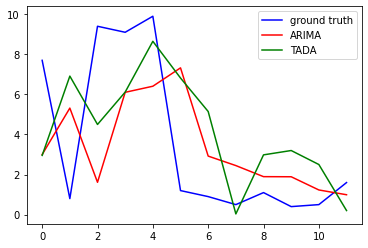

In [110]:
predictions_ARIMA = list()
# define model configuration
my_order = (2, 1, 2)
my_seasonal_order = (0, 0, 0, 0)
# split dataset
train, test = train_test_split(X, 12)
history = [x for x in train]

# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history,order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_ARIMA.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted ARIMA=%f, expected=%f' % (yhat, obs))
# evaluate forecasts ARIMA
rmse_ARIMA = sqrt(mean_squared_error(test, predictions_ARIMA))
print('Test RMSE ARIMA: %.3f' % rmse_ARIMA)


predictions_TADA=list()

#from features dataframe, we select only the last 12 rows
ft=features.iloc[-12:]
for i in range(len(ft)):
    i=int(i)
    current=ft.iloc[i, ]
    column_1 = float(current["T-2"])
    column_3 = float(current["T-6"])
    column_4 = float(current["T-1"])
    column_5 = float(current["T-10"])
    column_6 = float(current["T-17"])
    column_7 = float(current["T-5"])
    tzero = float(current["tzero"])
    target=float(current["Target_Tplus1"])
    yhat_TADA=0.240677198798674*column_4 + 0.0020811434064103*column_6 + 0.58962172176905*tzero - 0.00123650793945041*sqrt(abs(0.115938048371099*(column_3 + column_4) + 0.884061951628901*abs(column_4)))*column_4 - 0.000329377042421718*truncate(0.115938048371099*(column_3 + column_4) + 0.884061951628901*abs(column_4))*column_4 + 0.152240464761094*sqrt(abs(column_5)) - 0.622312003332226*sqrt(abs(column_6)) + 0.761777641582889*sqrt(abs(column_7)) + 0.0406427826989511*floor(column_5) + 0.323790283552682*floor(column_7) - 0.662946381672931*ceiling(0.701731898985275*sqrt(abs(column_7)) + 0.298268101014725*floor(column_7)) + 0.995189185299062*sin(tzero) - 0.000132057906492641*cos(column_4) + 0.507881246487279*cos(0.613916227969787*(column_1 - column_6) + 0.386083772030213*floor(column_1)) + 0.180216942273421*abs(0.613916227969787*(column_1 - column_6) + 0.386083772030213*floor(column_1))
    predictions_TADA.append(yhat_TADA)
    print('predicted TADA=%f, expected=%f' % (yhat_TADA, target))
#evaluate forecast TADA 
rmse_TADA = sqrt(mean_squared_error(test, predictions_TADA))
print('Test RMSE TADA: %.3f' % rmse_TADA)
# plot forecasts against actual outcomes
plt.plot(test,color='blue', label="ground truth")
plt.plot(predictions, color='red', label="ARIMA")
plt.plot(predictions_TADA, color='green',label="TADA")
plt.legend()
plt.show()

## Conclusion  

In our case study we obtain that the RMSE of the TADA model for the last 12 one step forward prediction is lower than the RMSE of the ARIMA (2,1,2) model